In [1]:
from SingleUESTA.network import Network
from SingleUESTA.node import Node
from SingleUESTA.link import Link
from SingleUESTA.path import Path
from SingleUESTA.od import OD
from SingleUESTA import utils


# Use your network files directory here
net = Network("/Users/alfredzhong/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/GeorgiaTech/Courses/25Fall/8803/Team2/SiouxFalls/SiouxFalls_net.tntp",
              "/Users/alfredzhong/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/GeorgiaTech/Courses/25Fall/8803/Team2/SiouxFalls/SiouxFalls_trips.tntp")


In [2]:

def run_assignment(solver):
    # reset flows and costs
    for lk in net.link.values():
        lk.flow = 0
        lk.updateCost()
    solver()
    tstt = sum(lk.flow * lk.cost for lk in net.link.values())
    total_demand = sum(od.demand for od in net.ODpair.values())
    avg_time = tstt / total_demand
    return {
        "flows": {k: lk.flow for k, lk in net.link.items()},
        "objective": net.beckmannFunction(),
        "tstt": tstt,
        "avg_time": avg_time,
        "history": net.convergenceHistory.copy() 
    }

ue = run_assignment(lambda: net.userEquilibriumFW(maxIterations=500, targetGap=1e-5))
so = run_assignment(lambda: net.systemOptimalFW(maxIterations=500, targetGap=1e-5))


print(f"UE Beckmann Objective={ue['objective']:.2f}, Avg Travel Time={ue['avg_time']:.2f}")
print(f"SO TSTT={so['tstt']:.2f}, Avg={so['avg_time']:.2f}")


Iteration 1: gap 1.350998; obj fun 7343713.635066
Iteration 2: gap 0.335859; obj fun 5934612.887807
Iteration 3: gap 0.246681; obj fun 5582791.661287
Iteration 4: gap 0.229356; obj fun 5203697.573176
Iteration 5: gap 0.135426; obj fun 5025449.328122
Iteration 6: gap 0.143406; obj fun 4787250.824585
Iteration 7: gap 0.084484; obj fun 4718133.618585
Iteration 8: gap 0.084116; obj fun 4625242.871348
Iteration 9: gap 0.060817; obj fun 4564713.172536
Iteration 10: gap 0.053743; obj fun 4518124.829096
Iteration 11: gap 0.058157; obj fun 4486870.825635
Iteration 12: gap 0.040859; obj fun 4454656.958249
Iteration 13: gap 0.033184; obj fun 4428230.287127
Iteration 14: gap 0.045977; obj fun 4415202.536053
Iteration 15: gap 0.032570; obj fun 4395069.461332
Iteration 16: gap 0.023584; obj fun 4367041.395181
Iteration 17: gap 0.025926; obj fun 4354213.792486
Iteration 18: gap 0.021509; obj fun 4340200.243953
Iteration 19: gap 0.020198; obj fun 4332167.947254
Iteration 20: gap 0.017499; obj fun 4325

We first expand the Single-class UE STA to SO STA, and then compare their performance. Originally the max iteration was 100, and we increased it to 500 to observe the convergence.

In [3]:
from multiclass_sta import MultiClassSTA

NETWORK_FILE = "SiouxFalls/SiouxFalls_net.tntp"
DEMAND_FILE = "SiouxFalls/SiouxFalls_trips.tntp"

mc_net = Network(NETWORK_FILE, DEMAND_FILE)
mc_sta = MultiClassSTA(mc_net)

scenario_configs = {
    "Scenario 1": {"hdv_share": 1.0, "rsu_links": []},
    "Scenario 2": {"hdv_share": 0.5, "rsu_links": []},
    "Scenario 3": {"hdv_share": 0.5, "rsu_links": ["(4,11)", "(10,15)"]},
}

scenario_results = {}
for name, cfg in scenario_configs.items():
    mc_sta.configure_demand_split(cfg["hdv_share"])
    mc_sta.configure_eta(0.1)
    mc_sta.configure_rsu_links(cfg["rsu_links"])
    ue_res = mc_sta.solve_user_equilibrium(maxIterations=500, targetGap=1e-5)
    so_res = mc_sta.solve_system_optimal(maxIterations=500, targetGap=1e-5)
    scenario_results[name] = {"UE": ue_res, "SO": so_res}
    print(f"{name}: UE avg={ue_res['avg_time']:.3f} (TSTT={ue_res['tstt']:.2f}), "
          f"SO avg={so_res['avg_time']:.3f} (TSTT={so_res['tstt']:.2f})")


Scenario 1: UE avg=76.881 (TSTT=27723209.35), SO avg=76.783 (TSTT=27687884.43)
Scenario 2: UE avg=43.588 (TSTT=15717832.44), SO avg=43.348 (TSTT=15631376.12)
Scenario 3: UE avg=43.537 (TSTT=15699347.13), SO avg=43.301 (TSTT=15614351.09)


Needs analysis

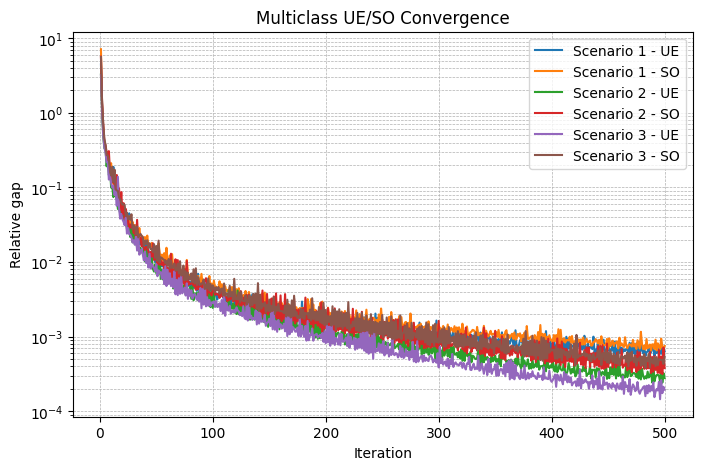

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for name, results in scenario_results.items():
    for label in ("UE", "SO"):
        history = results[label]["history"]
        if not history:
            continue
        iterations = [item["iteration"] for item in history]
        gaps = [max(item["gap"], 1e-12) for item in history]
        plt.semilogy(iterations, gaps, label=f"{name} - {label}")

plt.xlabel("Iteration")
plt.ylabel("Relative gap")
plt.title("Multiclass UE/SO Convergence")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()


In [ ]:
import pandas as pd

def run_sensitivity(penetration_rates=(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1), rsu_counts=(0,1,2,3,4,5), eta_values=(-0.3,-0.1,0.05,0.1,0.15,0.3), base_links=["(4,11)", "(10,15)", "(16,8)", "(8,16), (13,24)" ]):
    records = []
    for rate in penetration_rates:
        for eta in eta_values:
            for rsu_n in rsu_counts:
                links = base_links[:rsu_n]
                mc_sta.configure_demand_split(1-rate)  # HDV share = 1 - CV share
                mc_sta.configure_eta(eta)
                mc_sta.configure_rsu_links(links)
                ue_res = mc_sta.solve_user_equilibrium(maxIterations=300, targetGap=1e-5)
                so_res = mc_sta.solve_system_optimal(maxIterations=300, targetGap=1e-5)
                records.append({
                    "cv_share": rate,
                    "eta_c": eta,
                    "rsu_count": rsu_n,
                    "UE_avg": ue_res['avg_time'],
                    "UE_tstt": ue_res['tstt'],
                    "SO_avg": so_res['avg_time'],
                    "SO_tstt": so_res['tstt']
                })
    return pd.DataFrame(records)

sensitivity_df = run_sensitivity()
print(sensitivity_df.head())
sensitivity_df


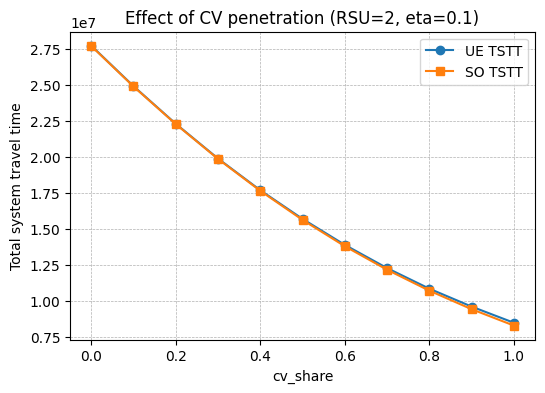

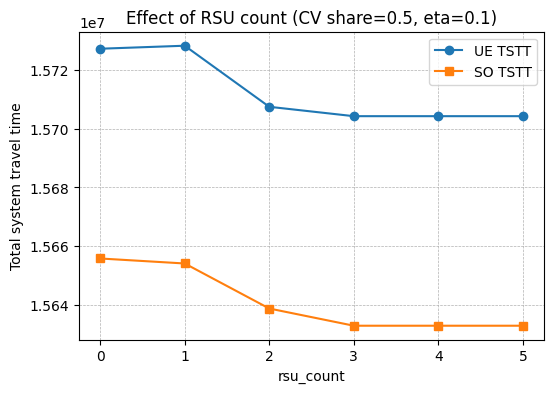

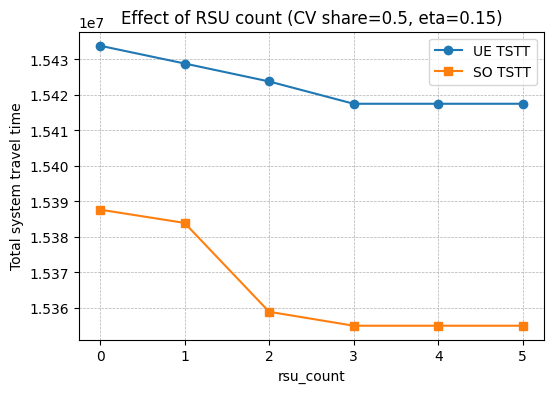

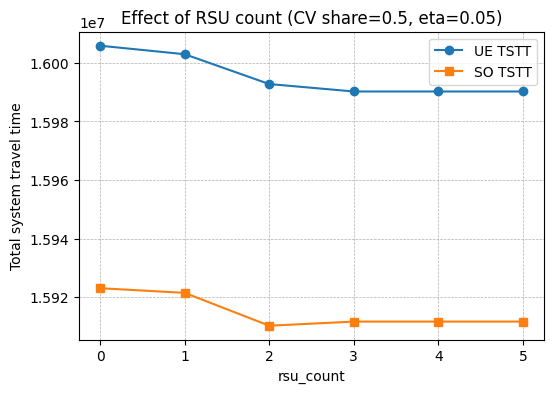

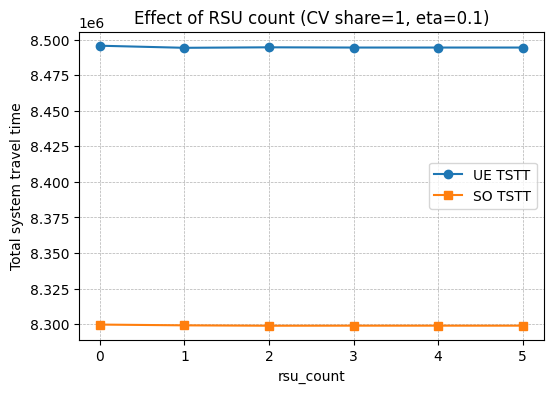

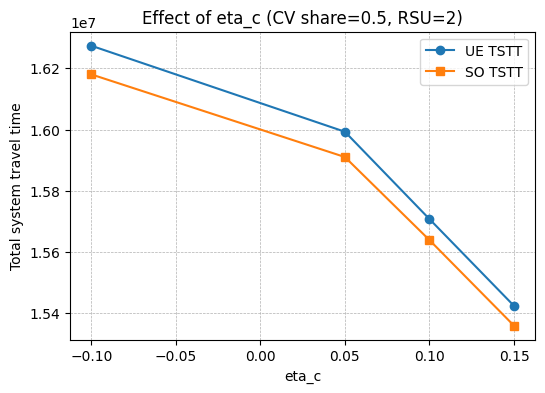

In [ ]:
import numpy as np

if 'sensitivity_df' not in globals():
    sensitivity_df = run_sensitivity()


def filter_df(df, filters):
    mask = np.ones(len(df), dtype=bool)
    for key, val in filters.items():
        column = df[key]
        if np.issubdtype(column.dtype, np.floating):
            mask &= np.isclose(column, val)
        else:
            mask &= (column == val)
    return df[mask]


def plot_trend(varying, values, fixed_filters, title):
    subset = filter_df(sensitivity_df, fixed_filters)
    subset = subset[subset[varying].isin(values)]
    subset = subset.sort_values(by=varying)
    plt.figure(figsize=(6,4))
    plt.plot(subset[varying], subset['UE_tstt'], marker='o', label='UE TSTT')
    plt.plot(subset[varying], subset['SO_tstt'], marker='s', label='SO TSTT')
    plt.xlabel(varying)
    plt.ylabel('Total system travel time')
    plt.title(title)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()


plot_trend('cv_share', [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], {'rsu_count':2, 'eta_c':0.1}, 'Effect of CV penetration (RSU=2, eta=0.1)')

plot_trend('rsu_count', [0,1,2,3,4,5], {'cv_share':0.5, 'eta_c':0.1}, 'Effect of RSU count (CV share=0.5, eta=0.1)')
plot_trend('rsu_count', [0,1,2,3,4,5], {'cv_share':0.5, 'eta_c':0.15}, 'Effect of RSU count (CV share=0.5, eta=0.15)')
plot_trend('rsu_count', [0,1,2,3,4,5], {'cv_share':0.5, 'eta_c':0.05}, 'Effect of RSU count (CV share=0.5, eta=0.05)')
plot_trend('rsu_count', [0,1,2,3,4,5], {'cv_share':1, 'eta_c':0.1}, 'Effect of RSU count (CV share=1, eta=0.1)')
plot_trend('eta_c', [-0.3,-0.1,0.05,0.1,0.15,0.3], {'cv_share':0.5, 'rsu_count':2}, 'Effect of eta_c (CV share=0.5, RSU=2)')

